In [1]:
import sys
sys.path.append('/home/royhirsch_google_com/image_editing')

import os
import pickle
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import torch
from functools import partial
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler, DPMSolverMultistepScheduler


In [65]:
sample_name = 'drawbench_19'
device = torch.device('cuda:0')
model_name = 'xl'
torch_dtype = torch.float16


def get_all_abs_filenames(dir_name):
    return [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

sample_name2dir = {
    'drawbench_64': '/home/royhirsch_google_com/image_editing/files/xl/drawbench_64',
    'drawbench_19': '/home/royhirsch_google_com/image_editing/files/xl/drawbench_19'
}
with open('/home/royhirsch_google_com/image_editing/sample_qa.json', 'r') as f:
    qa = json.load(f)

for sample in qa:
    if sample['id'] == sample_name:
        break

questions = sample['questions']
prompt = sample['prompt']
image_dir = sample_name2dir[sample_name]
image_paths = get_all_abs_filenames(image_dir)

# Generate TIFA scores for source images


In [66]:
from tifa_utils import TifaAutoRater

tifa = TifaAutoRater()

all_results = []
for path in image_paths:
    with open(path, 'rb') as f:
        results = pickle.load(f)
        all_results += results['results']
        print(f'Loaded {path}')
n_items = len(np.unique(np.array([item['seed'] for item in all_results])))
print(f'Loaded {n_items} unique items')

sample_source_tifa_scores_file = os.path.join(image_dir, f'{sample_name}_tifa_scores.pickle')
if not os.path.exists(sample_source_tifa_scores_file):
    seed2score = {}
    for item in all_results:
        # image = item['image'].astype(np.uint8)
        image = Image.fromarray(item['image'])
        score = tifa.get_score(image, questions)
        seed2score[item['seed']] = score

    with open(sample_source_tifa_scores_file, 'wb') as f:
        pickle.dump(
            {
                'seed2score': seed2score,
                'questions': questions,
                'prompt': prompt,
            },
            f)
        print(f'Saved Tifa scores to {sample_source_tifa_scores_file}')
else:
    with open(sample_source_tifa_scores_file, 'rb') as f:
        seed2score = pickle.load(f)['seed2score']
    print(f'Loaded Tifa scores from {sample_source_tifa_scores_file}')


Loading mplug-large...


2024-12-26 16:09:13,834 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-12-26 16:09:14,279 - modelscope - INFO - initiate model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-12-26 16:09:14,280 - modelscope - INFO - initiate model from location /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-12-26 16:09:14,282 - modelscope - INFO - initialize model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
/opt/conda/envs/ml/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2102: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
/home/royhirsch_google_com/.local/lib/python3.8/site-packages/modelscope/mode

load checkpoint from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>
Finish loading mplug-large
Using SBERT on GPU
Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_19/SDxl_drawbench_19_1.pickle
Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_19/SDxl_drawbench_19_3.pickle
Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_19/SDxl_drawbench_19_0.pickle
Loaded /home/royhirsch_google_com/image_editing/files/xl/drawbench_19/SDxl_drawbench_19_2.pickle
Loaded 100 unique items


  0%|          | 0/6 [00:00<?, ?it/s]/opt/conda/envs/ml/lib/python3.8/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/envs/ml/lib/python3.8/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00,  7.21it/s]

Saved Tifa scores to /home/royhirsch_google_com/image_editing/files/xl/drawbench_19/drawbench_19_tifa_scores.pickle


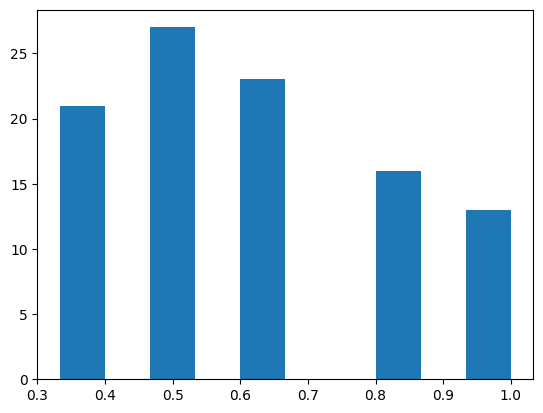

In [67]:
num_samples = len(all_results)
_ = plt.hist(list(seed2score.values())[:num_samples])

# Calc moving vectors

In [68]:
# results['results'] is a list of dicts
# the key 'h_space' is a dict, each entry is a list of tensors

layer_name = 'down_zero'

# seed2h_space Dict[int, List[torch.tensor]]
seed2image = {}
seed2h_space = {}
for item in all_results[:num_samples]:
    seed2h_space[item['seed']] = item['h_space'][layer_name]
    seed2image[item['seed']] = item['image']

thresh = 0.8
pos_examples = [h_space for ind, h_space in seed2h_space.items() if seed2score[ind] >= thresh]
neg_examples = [h_space for ind, h_space in seed2h_space.items() if seed2score[ind] < thresh]
print('Num pos: {} Num neg: {}'.format(len(pos_examples), len(neg_examples)))


def get_average_list(h_space_list):
    num_steps = len(h_space_list[0])
    mean_latents = []
    for i in range(num_steps):
        mean_latents.append(torch.stack([item[i].detach().cpu() for item in h_space_list]).mean(0))
    return mean_latents


pos_mid  = get_average_list(pos_examples)
neg_mid  = get_average_list(neg_examples)
print('Num moving tensor (denoising steps): {}\nShape of a single moving tensor: {}'.format(len(pos_mid), pos_mid[0].shape))
print('\nNum moving tensor (denoising steps): {}\nShape of a single moving tensor: {}'.format(len(neg_mid), neg_mid[0].shape))

move_vectors = [p - n for p, n in zip(pos_mid, neg_mid)]
rand_move_vectors = [torch.rand_like(item) for item in move_vectors]

Num pos: 29 Num neg: 71
Num moving tensor (denoising steps): 50
Shape of a single moving tensor: torch.Size([2, 320, 64, 64])

Num moving tensor (denoising steps): 50
Shape of a single moving tensor: torch.Size([2, 320, 64, 64])


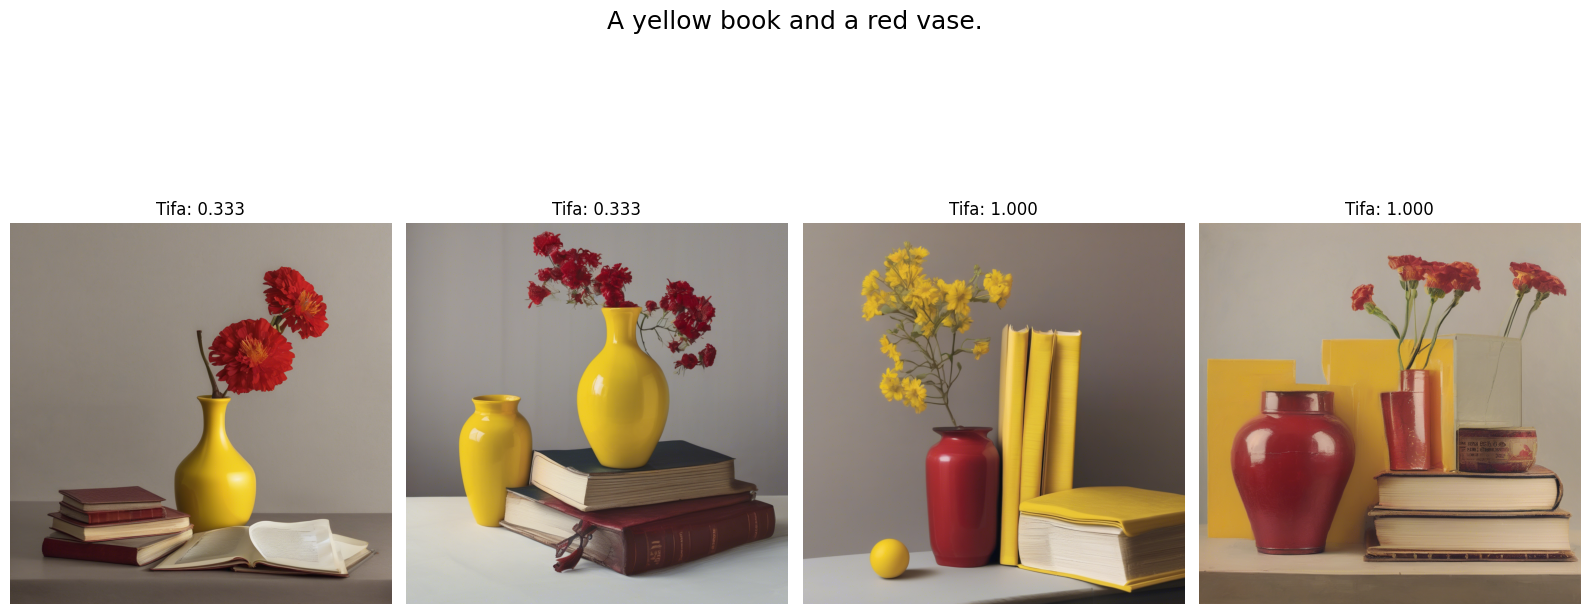

In [69]:
sorted_seed_and_scores = sorted(seed2score.items(), key=lambda kv: kv[1])
fig, axes = plt.subplots(1, 4, figsize=(16, 8)) 
plt.suptitle(prompt, fontsize=18)
for ind, i in enumerate([0, 1, -2, -1]):
    seed, score = sorted_seed_and_scores[i]
    axes[ind].imshow(seed2image[seed])
    axes[ind].set_title('Tifa: {:.3f}'.format(score))
    axes[ind].axis('off')
plt.tight_layout()
plt.show()

# Manipulate

In [70]:
from sd_utils import get_sd_pipe, _GENERATION_CONFIGS

pipe = get_sd_pipe(model_name, device, torch_dtype)
config = _GENERATION_CONFIGS[model_name]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  7.02it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.97it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.94it/s]


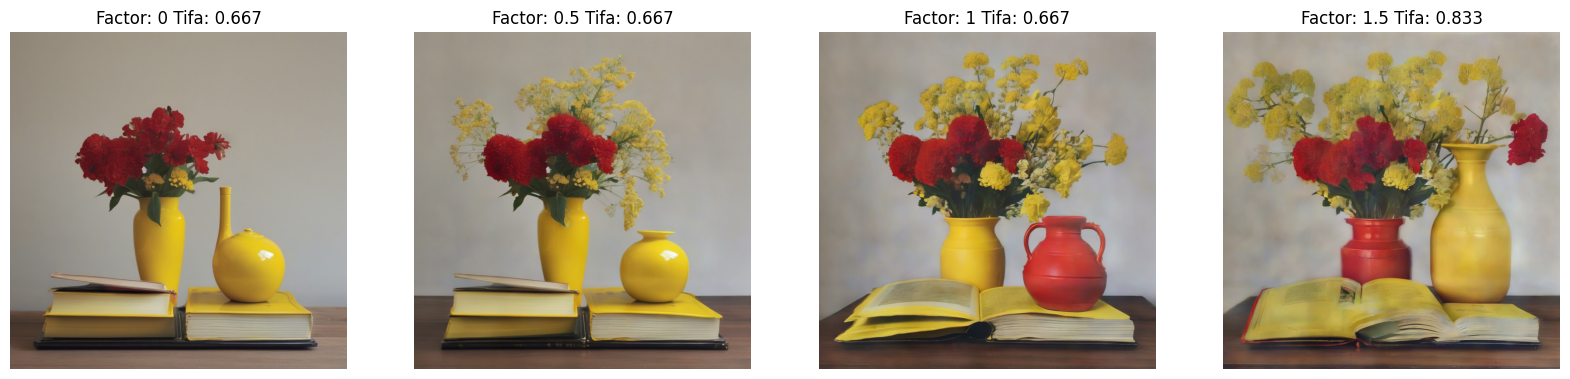

In [74]:
factors = [0, 0.5, 1, 1.5]
seed = 86
calc_tifa  = True

def modify_down_h_space(module, input, output, factor, step=[0]):
    sample = output[0]
    change = factor * move_vectors[step[0]].to(sample.device)
    step[0] += 1
    sample += change
    return tuple([sample] + list(output[1:]))

def modify_mid_h_space(module, input, output, factor, step=[0]):
    change = factor * move_vectors[step[0]].to(output.device)
    step[0] += 1
    return output + change

modify_h_space_func = modify_down_h_space if 'down' in layer_name else modify_mid_h_space

fig, axes = plt.subplots(1, len(factors), figsize=(len(factors) * 5, 10)) 
with torch.no_grad():
    for ind, factor in enumerate(factors):
        if 'down' in layer_name:
            num = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}[layer_name.split('_')[1]]
            hook = pipe.unet.down_blocks[num].register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
        else:
            hook = pipe.unet.mid_block.register_forward_hook(
                partial(modify_h_space_func, factor=factor, step=[0]))
            
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe(prompt, generator=generator, **config).images[0]
        hook.remove()
        
        axes[ind].imshow(image)
        if calc_tifa:
            score = tifa.get_score(image, questions)
            axes[ind].set_title('Factor: {} Tifa: {:.3f}'.format(factor, score))
        else:
            
            axes[ind].set_title('Factor: {}'.format(factor))
        axes[ind].axis('off')

plt.show()

# Quantiative results 

In [ ]:
# generate images

factors = [0, 1, 2, 3]
init_seed = 300
num_samples = 50
modify_h_space_func = modify_down_h_space if 'down' in layer_name else modify_mid_h_space

factor2images = {i:[] for i in factors}
with torch.no_grad():
    for seed in range(init_seed, init_seed + num_samples):
        print('###' + str(seed) + '###')
        for ind, factor in enumerate(factors):
            if 'down' in layer_name:
                num = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}[layer_name.split('_')[1]]
                hook = pipe.unet.down_blocks[num].register_forward_hook(
                    partial(modify_h_space_func, factor=factor, step=[0]))
            else:
                hook = pipe.unet.mid_block.register_forward_hook(
                    partial(modify_h_space_func, factor=factor, step=[0]))
                
            generator = torch.Generator(device=device).manual_seed(seed)
            image = pipe(prompt, generator=generator).images[0]
            hook.remove()
            factor2images[factor].append(image)

with open(f'/home/royhirsch_google_com/image_editing/cat_dog_images/{sample_name}_factor2eval_images.pickle', 'wb') as f:
    pickle.dump(factor2images, f)


###300###


  0%|          | 0/50 [00:00<?, ?it/s]

IndexError: list index out of range

## PickScore

In [ ]:
# # pic a score
# from transformers import AutoProcessor, AutoModel

# # load model
# device = "cuda"
# processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
# model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"

# processor = AutoProcessor.from_pretrained(processor_name_or_path)
# model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)

# def calc_probs(prompt, images):
    
#     # preprocess
#     image_inputs = processor(
#         images=images,
#         padding=True,
#         truncation=True,
#         max_length=77,
#         return_tensors="pt",
#     ).to(device)
    
#     text_inputs = processor(
#         text=prompt,
#         padding=True,
#         truncation=True,
#         max_length=77,
#         return_tensors="pt",
#     ).to(device)


#     with torch.no_grad():
#         # embed
#         image_embs = model.get_image_features(**image_inputs)
#         image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)
    
#         text_embs = model.get_text_features(**text_inputs)
#         text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)
    
#         # score
#         scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]
        
#         # get probabilities if you have multiple images to choose from
#         probs = torch.softmax(scores, dim=-1)
    
#     return probs.cpu().tolist()

# with open('/home/royhirsch_google_com/image_editing/cat_dog_images/factor2eval_images.pickle', 'rb') as f:
#     factor2images = pickle.load(f)

# factor2pick_scores = {f:[] for f in factor2images.keys()}
# for f, pil_images in factor2images.items():
#     # pil_images = [Image.fromarray(image) for image in images]
#     factor2pick_scores[f] = np.asarray(calc_probs(prompt, pil_images))

In [ ]:
base_scores = factor2pick_scores[0]
cand_scores = factor2pick_scores[1]
hits = []
for b, c in zip(base_scores, cand_scores):
    hits.append(c > b)
print(np.mean(hits))

## TifaScore

In [9]:
from tifa_utils import TifaAutoRater
tifa = TifaAutoRater()

Loading mplug-large...


2024-12-24 13:11:17,678 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-12-24 13:11:18,270 - modelscope - INFO - initiate model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-12-24 13:11:18,271 - modelscope - INFO - initiate model from location /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-12-24 13:11:18,274 - modelscope - INFO - initialize model from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en


load checkpoint from /home/royhirsch_google_com/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>
Finish loading mplug-large
Using SBERT on GPU


In [10]:
factor2tifa_scores = {f:[] for f in factor2images.keys()}
for f, pil_images in factor2images.items():
    for image in pil_images:
        factor2tifa_scores[f].append(tifa.get_score(image, questions))
for k, v in factor2tifa_scores.items():
    factor2tifa_scores[k] = np.asarray(v)

100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


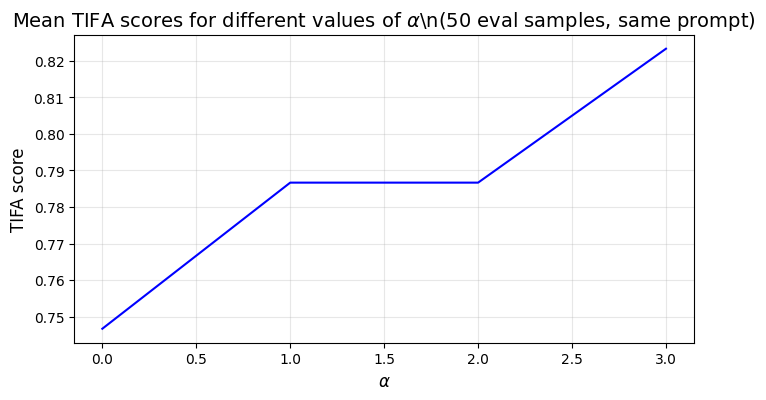

In [14]:
x = list(factor2tifa_scores.keys())
means = np.asarray([np.mean(v) for v in factor2tifa_scores.values()])
stds = np.asarray([np.std(v) for v in factor2tifa_scores.values()])
plt.figure(figsize=(8, 4))
plt.plot(x, means, label='Mean', color='blue')

# plt.fill_between(x, means - stds, means + stds, color='blue', alpha=0.2, label='Mean ± Std Dev')

# Add labels and legend
plt.title(r"Mean TIFA scores for different values of $\alpha$\n(50 eval samples, same prompt)", fontsize=14)
plt.xlabel(r"$\alpha$", fontsize=12)
plt.ylabel("TIFA score", fontsize=12)
# plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [15]:
np.round(means, 2)

array([0.75, 0.79, 0.79, 0.82])